In [1]:
!pip install yfinance
!pip install pmdarima
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00


In [2]:
# Download Tesla stock data
stock_data = yf.download('TSLA', start='2015-01-01', end='2023-10-01')

# Display the first few rows
stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500


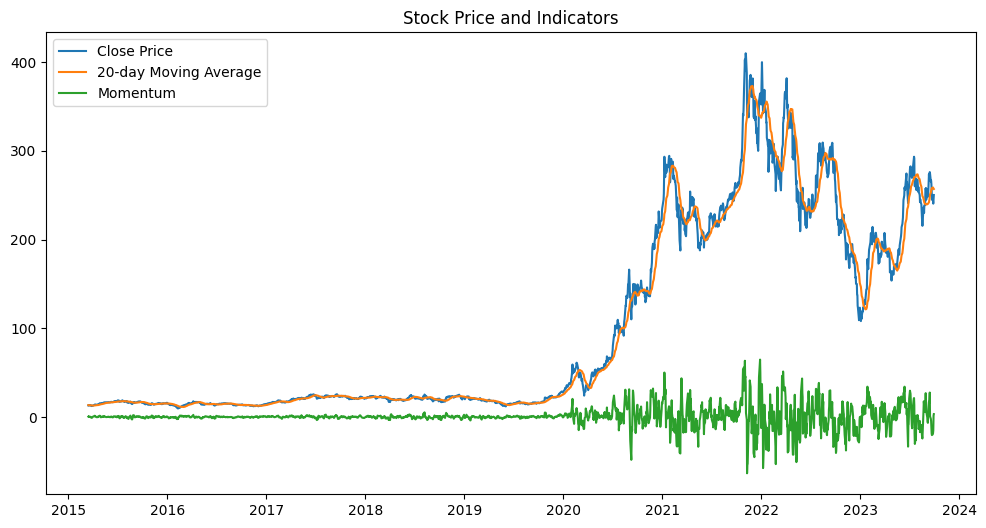

In [3]:
# Moving Average (MA)
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()

# Momentum
stock_data['Momentum'] = stock_data['Close'].diff(4)

# Volume Weighted Average Price (VWAP)
stock_data['VWAP'] = (stock_data['Close'] * stock_data['Volume']).cumsum() / stock_data['Volume'].cumsum()

# Drop NaN values created by rolling windows
stock_data = stock_data.dropna()

# Plot some of the new features
plt.figure(figsize=(12,6))
plt.plot(stock_data['Close'], label='Close Price')
plt.plot(stock_data['MA_20'], label='20-day Moving Average')
plt.plot(stock_data['Momentum'], label='Momentum')
plt.title('Stock Price and Indicators')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

2152    249.957631
2153    249.876962
2154    250.308706
2155    250.390149
2156    250.292688
2157    250.298571
2158    250.324434
2159    250.318811
2160    250.311782
2161    250.314475
2162    250.315681
2163    250.314766
2164    250.314524
2165    250.314836
2166    250.314833
2167    250.314756
2168    250.314765
2169    250.314787
2170    250.314780
2171    250.314776
2172    250.314778
2173    250.314779
2174    250.314778
2175    250.314778
2176    250.314778
2177    250.314778
2178    250.314778
2179    250.314778
2180    250.314778
2181    250.314778
Name: predicted_mean, dtype: float64


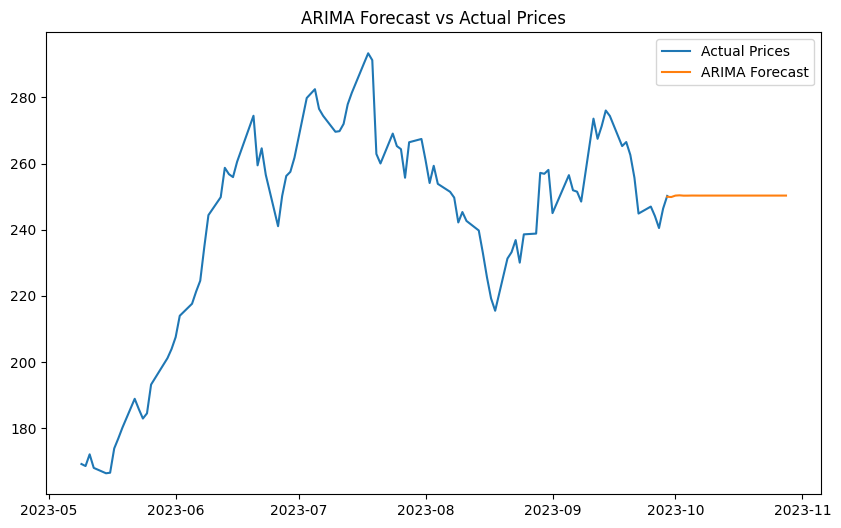

In [4]:
# ARIMA Model
arima_model = ARIMA(stock_data['Close'], order=(5,1,0))
arima_result = arima_model.fit()

# Make predictions
arima_forecast = arima_result.forecast(steps=30)
print(arima_forecast)

# Plot forecast
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[-100:], stock_data['Close'][-100:], label='Actual Prices')
plt.plot(pd.date_range(stock_data.index[-1], periods=30, freq='D'), arima_forecast, label='ARIMA Forecast')
plt.title('ARIMA Forecast vs Actual Prices')
plt.legend()
plt.show()


In [5]:
# Prepare data for LSTM model
data = stock_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences of 60 timesteps
def create_sequences(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=5)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 0.0378
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0018
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 8.3352e-04
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 7.6687e-04
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 7.0686e-04
